# Statsmodels: Python's library for Statistical Analysis

**Statsmodels mimics R-style formulas with pandas data frames to fit models**

- Generalized Linear Models
- Linear Mixed Models
- ANOVA
- ARIMA
- State Space Models (those are Generalized forms or ARIMA)

One of the weaknesses in python is the lack of uniformity, statsmodels has a different design and interface than scikit-learn and different than the deep learning libraries. Therefore out of the box one can't call statsmodels from scikit-learn

**Surviving the titanice, logistic regression using Stats Models**

In [1]:
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import *;

C:\Users\zikka\Anaconda3\envs\py36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**Loading the Titanic dataset and performing high level data structure review**

In [2]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### High level data structure review and features modifications

In [3]:
titanic[["age","fare"]].describe()

,age,fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200


In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
survived       891 non-null int64
pclass         891 non-null int64
sex            891 non-null object
age            714 non-null float64
sibsp          891 non-null int64
parch          891 non-null int64
fare           891 non-null float64
embarked       889 non-null object
class          891 non-null category
who            891 non-null object
adult_male     891 non-null bool
deck           203 non-null category
embark_town    889 non-null object
alive          891 non-null object
alone          891 non-null bool
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB


**We're interested in the missing age fields** 

In [5]:
titanic[titanic['who']=='child']["age"].isnull().value_counts()

False    83
Name: age, dtype: int64

In [6]:
titanic[titanic['who']=='man']["age"].isnull().value_counts()

False    413
True     124
Name: age, dtype: int64

This is telling us that age is missing for some adults only. So we can set up age to be the mean for missing women ages, and mean for men missing ages

In [7]:
age_men=titanic[titanic['who']=='man']["age"].mean()
age_women=titanic[titanic['who']=='woman']["age"].mean()

In [8]:
for i in range(len(titanic["age"])):
    if np.isnan(titanic.loc[i,"age"])==True:
        if titanic.loc[i,"who"]=="man":
            titanic.loc[i,"age"]=age_men
        else:
            titanic.loc[i,"age"]=age_women

In [9]:
titanic[titanic["age"].isnull()]

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone


This came back empty, so we've got this covered

In [10]:
titanic["family_size"]=titanic["sibsp"]+titanic["parch"]+1

In [11]:
titanic["ischild"]=titanic["who"].apply(lambda x: 1 if x=="child" else 0)

In [12]:
# Creating dummy variables for the categorical variabes
categorical_cols = ['sex','class']
for c in categorical_cols:    
    titanic=titanic.join(pd.get_dummies(titanic[c],drop_first=True))

# NOTE:
**See how we used the option ``drop_first=True``, this is important otherwise we will end up overfitting the model**
Meaning if we know Sex of one passenger is Male, we then know that it's not female. So there is no need to add Female as a variable

### Spliting Data set into training and test

To preserve the distribution of survived vs didn't survive we will use StratifiedShuffleSplit() to stratify the split

In [13]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2301) # Creating A split object
for train_index, test_index in split.split(titanic, titanic["survived"]):
    strat_train_set = titanic.loc[train_index]
    strat_test_set = titanic.loc[test_index]

In [14]:
titanic_df=strat_train_set.copy()

In [15]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 599 to 737
Data columns (total 20 columns):
survived       712 non-null int64
pclass         712 non-null int64
sex            712 non-null object
age            712 non-null float64
sibsp          712 non-null int64
parch          712 non-null int64
fare           712 non-null float64
embarked       710 non-null object
class          712 non-null category
who            712 non-null object
adult_male     712 non-null bool
deck           165 non-null category
embark_town    710 non-null object
alive          712 non-null object
alone          712 non-null bool
family_size    712 non-null int64
ischild        712 non-null int64
male           712 non-null uint8
Second         712 non-null uint8
Third          712 non-null uint8
dtypes: bool(2), category(2), float64(2), int64(6), object(5), uint8(3)
memory usage: 83.2+ KB


### Perform exploratory analysis and Features modifications

Let's do a histogram and distribution plot to compare the Age by Survived and class

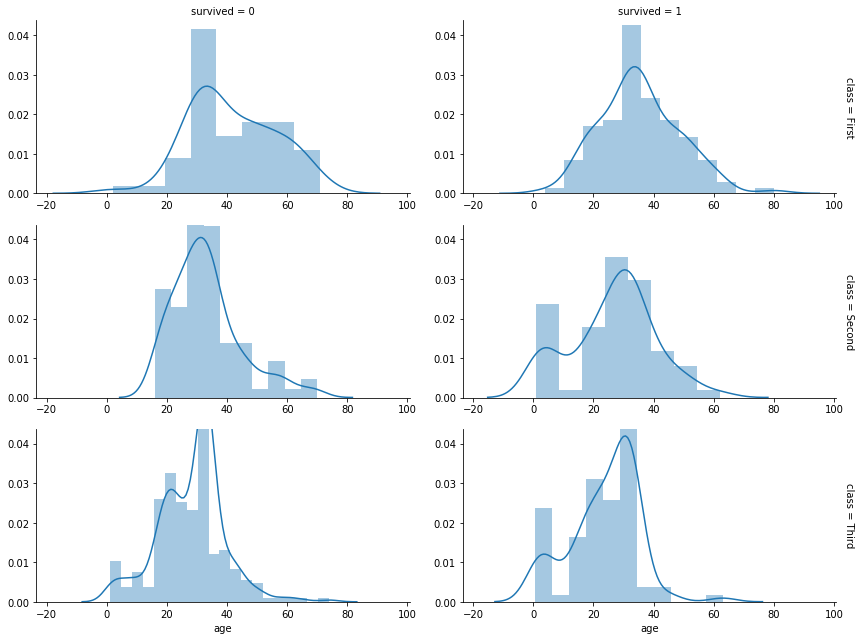

In [16]:
g = sns.FacetGrid(titanic_df, col="survived", row = 'class', size=3, aspect=2,margin_titles=True)
g.map(sns.distplot, "age", hist=True,rug=False);

Let's perform some box plots on the continuous variables

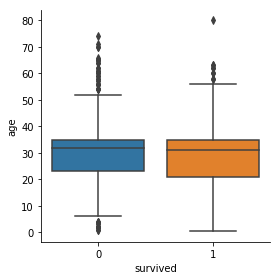

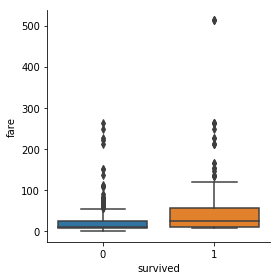

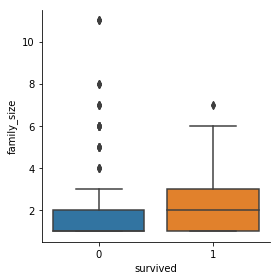

In [17]:
sns.factorplot(x="survived", y="age", data=strat_train_set, kind="box",size=4, aspect=1);
sns.factorplot(x="survived", y="fare", data=strat_train_set, kind="box",size=4, aspect=1);
sns.factorplot(x="survived", y="family_size", data=strat_train_set, kind="box",size=4, aspect=1);

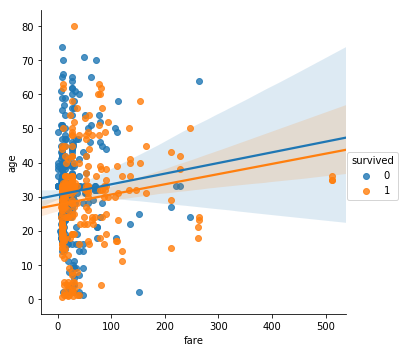

In [18]:
sns.lmplot(x="fare" , y="age", hue="survived", data=strat_train_set,scatter=True);

In [19]:
titanic_df["fare_sqrd"]=titanic_df["fare"]**2

In [20]:
titanic_df.head(20)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,...,deck,embark_town,alive,alone,family_size,ischild,male,Second,Third,fare_sqrd
599,1,1,male,49.000000,1,0,56.9292,C,First,man,...,A,Cherbourg,yes,False,2,0,1,0,0,3240.933813
362,0,3,female,45.000000,0,1,14.4542,C,Third,woman,...,NaN,Cherbourg,no,False,2,0,0,0,1,208.923898
520,1,1,female,30.000000,0,0,93.5000,S,First,woman,...,B,Southampton,yes,True,1,0,0,0,0,8742.250000
157,0,3,male,30.000000,0,0,8.0500,S,Third,man,...,NaN,Southampton,no,True,1,0,1,0,1,64.802500
807,0,3,female,18.000000,0,0,7.7750,S,Third,woman,...,NaN,Southampton,no,True,1,0,0,0,1,60.450625
536,0,1,male,45.000000,0,0,26.5500,S,First,man,...,B,Southampton,no,True,1,0,1,0,0,704.902500
531,0,3,male,33.173123,0,0,7.2292,C,Third,man,...,NaN,Cherbourg,no,True,1,0,1,0,1,52.261333
227,0,3,male,20.500000,0,0,7.2500,S,Third,man,...,NaN,Southampton,no,True,1,0,1,0,1,52.562500
866,1,2,female,27.000000,1,0,13.8583,C,Second,woman,...,NaN,Cherbourg,yes,False,2,0,0,1,0,192.052479
669,1,1,female,32.000000,1,0,52.0000,S,First,woman,...,C,Southampton,yes,False,2,0,0,0,0,2704.000000


### Fit and Tune models to Training data

** In *Statsmodels* the following steps take place**
- Define the model: by calling logistic regression and passing X and Y
```python
model=sm.Logit(y, X)
```
- We then fit the model object
```python
model=model.fit()
```
- Finally we perform prediction
```python
prediction=model.predict(X)
```


In [21]:
X_train=titanic_df[["age","fare","Second","Third","male","ischild","family_size"]]
y_train=titanic_df["survived"]

**Instatiating the model**

In [22]:
model_logit=sm.Logit(y_train, X_train)

**Fitting the model**

In [23]:
model_logit=model_logit.fit()

Optimization terminated successfully.
         Current function value: 0.466994
         Iterations 6


**Performing Predictions**

In [24]:
pred_train=model_logit.predict(X_train)

In [25]:
model_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      705
Method:                           MLE   Df Model:                            6
Date:                Tue, 27 Mar 2018   Pseudo R-squ.:                  0.2985
Time:                        18:20:26   Log-Likelihood:                -332.50
converged:                       True   LL-Null:                       -473.99
                                        LLR p-value:                 3.613e-58
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
age             0.0315      0.007      4.768      0.000       0.019       0.044
fare            0.0141      0.003      4.197      0.000       0.008       0.021
Second          0.4102      0.261      1.573      0.116      -0.101       0.921
Third          -0.3905      0.234     -1.672      0.094      -0.848       0.067
male           -2.4646      0.210    -11.723      0.000      -2.877      -2.053
ischild         2.4395      0.449      5.433      0.000       1.559       3.320
family_size    -0.3245      0.084     -3.857      0.000      -0.489      -0.160
===============================================================================
"""

In [26]:
model_logit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.299     
Dependent Variable: survived         AIC:              678.9993  
Date:               2018-03-27 18:20 BIC:              710.9758  
No. Observations:   712              Log-Likelihood:   -332.50   
Df Model:           6                LL-Null:          -473.99   
Df Residuals:       705              LLR p-value:      3.6133e-58
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
age           0.0315    0.0066    4.7681  0.0000   0.0186   0.0445
fare          0.0141    0.0034    4.1970  0.0000   0.0075   0.0208
Second        0.4102    0.2608    1.5729  0.1157  -0.1009   0.9214
Third        -0.3905    0.2335   -1.6721  0.0945  -0.8482   0.0672
male         -2.4646    0.2102  -11.7229  0.0000  -2.8767  -2.0526
ischild       2.4395    0.4490    5.4326  0.0000   1.5594   3.3196
family_size  -0.3245    0.0841   -3.8572  0.0001  -0.4893  -0.1596
=================================================================

"""

We will now assess how well this model performed:

- Score: gives us overall model error rate. Total number of correct predictions/Total number of Observations

- Confusion Matrix: Let's us see how well the model performed in each Category

In [27]:
titanic_df["prob_predict"]=pred_train
titanic_df["y_pred"]=titanic_df["prob_predict"].apply(lambda x: 0 if x<0.5 else 1)

In [28]:
confusion = confusion_matrix(y_train, titanic_df["y_pred"])
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[395  44]
 [100 173]]


In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.89977221  0.10022779]
 [ 0.36630037  0.63369963]]


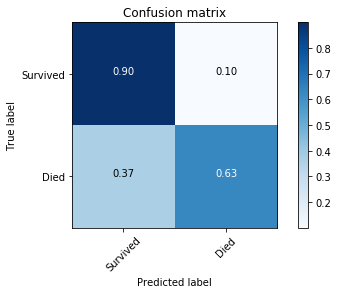

In [30]:
plot_confusion_matrix(confusion,classes=["Survived","Died"],normalize=True)

Let's See if adding the squared fare will make the model better

In [31]:
X_train=titanic_df[["age","fare","fare_sqrd","Second","Third","male","ischild","family_size"]]
y_train=titanic_df["survived"]

**Instatiating the model**

In [32]:
model_logit=sm.Logit(y_train, X_train)

**Fitting the model**

In [33]:
model_logit=model_logit.fit()

Optimization terminated successfully.
         Current function value: 0.461639
         Iterations 6


**Performing Predictions**

In [34]:
pred_train=model_logit.predict(X_train)

In [35]:
model_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      704
Method:                           MLE   Df Model:                            7
Date:                Tue, 27 Mar 2018   Pseudo R-squ.:                  0.3066
Time:                        18:22:38   Log-Likelihood:                -328.69
converged:                       True   LL-Null:                       -473.99
                                        LLR p-value:                 6.126e-59
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
age             0.0258      0.007      3.708      0.000       0.012       0.039
fare            0.0258      0.005      4.741      0.000       0.015       0.037
fare_sqrd    -3.95e-05   1.23e-05     -3.200      0.001   -6.37e-05   -1.53e-05
Second          0.5386      0.265      2.031      0.042       0.019       1.058
Third          -0.1876      0.243     -0.772      0.440      -0.664       0.289
male           -2.5087      0.213    -11.772      0.000      -2.926      -2.091
ischild         2.3675      0.457      5.181      0.000       1.472       3.263
family_size    -0.4051      0.091     -4.454      0.000      -0.583      -0.227
===============================================================================
"""

In [36]:
model_logit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.307     
Dependent Variable: survived         AIC:              673.3743  
Date:               2018-03-27 18:23 BIC:              709.9190  
No. Observations:   712              Log-Likelihood:   -328.69   
Df Model:           7                LL-Null:          -473.99   
Df Residuals:       704              LLR p-value:      6.1262e-59
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
age           0.0258    0.0069    3.7077  0.0002   0.0121   0.0394
fare          0.0258    0.0055    4.7406  0.0000   0.0152   0.0365
fare_sqrd    -0.0000    0.0000   -3.1998  0.0014  -0.0001  -0.0000
Second        0.5386    0.2652    2.0309  0.0423   0.0188   1.0584
Third        -0.1876    0.2430   -0.7721  0.4400  -0.6638   0.2886
male         -2.5087    0.2131  -11.7722  0.0000  -2.9263  -2.0910
ischild       2.3675    0.4569    5.1814  0.0000   1.4719   3.2630
family_size  -0.4051    0.0910   -4.4536  0.0000  -0.5834  -0.2268
=================================================================

"""

**Not much improvement in BIC**

**Performing Predictions**

In [40]:
pred_train=model_logit.predict(X_train)

In [41]:
titanic_df["prob_predict"]=pred_train
titanic_df["y_pred"]=titanic_df["prob_predict"].apply(lambda x: 0 if x<0.5 else 1)

In [42]:
confusion = confusion_matrix(y_train, titanic_df["y_pred"])
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[388  51]
 [ 93 180]]


Normalized confusion matrix
[[ 0.88382688  0.11617312]
 [ 0.34065934  0.65934066]]


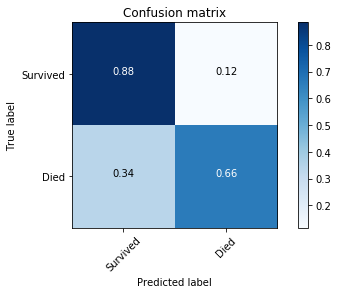

In [44]:
plot_confusion_matrix(confusion,classes=["Survived","Died"],normalize=True)

**Can We do better?**

<!--NAVIGATION-->
##### <[Data visualization](03_viz.ipynb) | [Contents](00_Index.ipynb#4--Statistical-Analysis-with-StatsModels) | [Machine Learning with Scikit-Learn](05_scikit.ipynb) >